# **Lab 9: Hypothesis Testing**

**Name:** Kushal Regmi

**Roll Number:** 080BCT042 

---



## **1. Theory and Terminology**
This section explains the key concepts and statistical methods used in this analysis.

### **1.1 Round Trip Time (RTT)**
**RTT (Round Trip Time)** measures the time taken for a data packet to travel from a source to a destination and back. It is commonly used to assess **network performance**, where **lower RTT** values indicate faster and more efficient communication.

### **1.1 Hypothesis Testing**
**Hypothesis testing** is a statistical method used to evaluate claims about a population based on sample data. It involves:
- **Null Hypothesis (H₀):** Represents the assumption that there is no significant difference or effect.
- **Alternative Hypothesis (Hₐ):** Represents the claim that there is a significant difference or effect.

In this study, we are testing whether the new networking component has significantly reduced RTT.

### **1.3 Two-Sample t-Test**
A **two-sample t-test** is used to compare the means of two independent groups. Since we do **not know** the population distribution of RTT values, and the sample sizes may be small, we use **Welch’s t-test**, which does not assume equal variances.

The test statistic for the two-sample t-test is given by:

```
t = (mean(old) - mean(new) - C) / sqrt((var(old)/n1) + (var(new)/n2))
```

where:  
- `mean(old)`, `mean(new)`: Sample means of old and new RTTs  
- `var(old)`, `var(new)`: Sample variances of old and new RTTs  
- `n1`, `n2`: Sample sizes of old and new RTTs  
- `C`: The claimed reduction in RTT (800ms)  

### **1.4 p-Value and Significance Level**
The **p-value** measures the probability of obtaining test results at least as extreme as the observed results, assuming that the null hypothesis is true.  
- If  
  ```
  p-value < 0.05
  ```
  we **reject H₀**, meaning there is strong evidence to support the claim.
- If  
  ```
  p-value ≥ 0.05
  ```
  we **fail to reject H₀**, meaning there is insufficient evidence to support the claim.

The **significance level (α) is set at 0.05**, which means we are willing to accept a 5% chance of rejecting a true null hypothesis.

### **1.5 One-Tailed vs. Two-Tailed Tests**
- A **one-tailed test** is used when we have a **directional** claim (e.g., RTT has **decreased by more than** 800ms).
- A **two-tailed test** is used when we test for **any** difference (increase or decrease).

Since our hypothesis states that the **new component reduces RTT by more than 800ms**, we use a **one-tailed t-test**.

---

### **1.6 Test for Difference in Means**
To further analyze the robustness of our test, we introduce a variable **δc**, which is incrementally increased to observe the change in **p-value**.

- **If our hypothesis is H₀:**
  ```
  mean(old) - mean(new) ≤ C
  ```
  we adjust it as:
  ```
  H₀: mean(old) - mean(new) = C - δc
  ```
  and increase **δc** in fixed steps.

- **If our hypothesis is H₀:**
  ```
  mean(old) - mean(new) ≥ C
  ```
  we adjust it as:
  ```
  H₀: mean(old) - mean(new) = C + δc
  ```

This stepwise approach helps **visualize the sensitivity of our hypothesis test**.

---




In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [76]:

# Read the file
with open("./rtt_current.txt", "r") as file:
    data = file.read().strip()  # Remove leading/trailing spaces and newlines

# Convert the string into a list of floats
old_data = [float(num) for num in data.replace("\n", " ").replace(",", " ").split()]

# Convert to NumPy array
old_data = np.array(old_data)


In [77]:

# Read the file
with open("./rtt_current.txt", "r") as file:
    data = file.read().strip()  # Remove leading/trailing spaces and newlines

# Convert the string into a list of floats
new_data = [float(num) for num in data.replace("\n", " ").replace(",", " ").split()]

# Convert to NumPy array
new_data = np.array(new_data)


### Hypothesis Formulation

#### Null Hypothesis (H₀):  
The improvement in RTT is **at most** 800ms, meaning:  

```
mean(old) - mean(new) <= 800
```

This represents the scenario where the vendor’s claim is **false** (i.e., the improvement is **not more than 800ms**).  

#### Alternative Hypothesis (H₁):  
The improvement in RTT is **greater than** 800ms, meaning:  

```
mean(old) - mean(new) > 800
```

This represents the claim made by the vendor, meaning the new software component has significantly reduced RTT.



In [78]:
# Compute mean and standard deviation
mean_old = np.mean(old_data)
mean_new = np.mean(new_data)
std_old = np.std(old_data, ddof=1)  # Sample standard deviation
std_new = np.std(new_data, ddof=1)
n_old = len(old_data)
n_new = len(new_data)

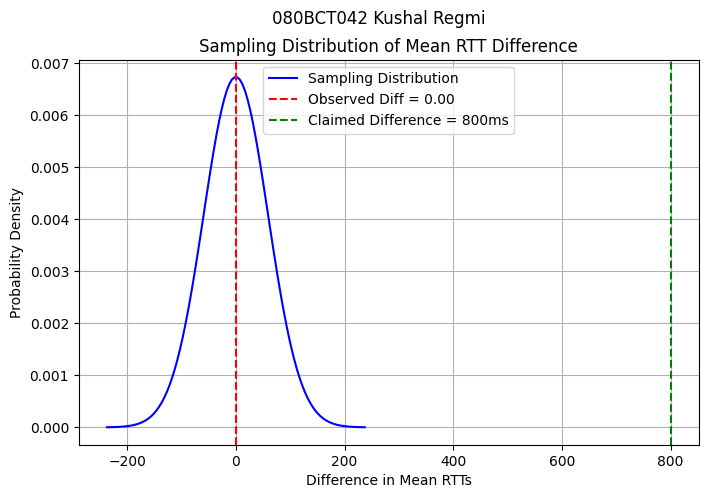

In [79]:


# Compute mean difference and standard error
mean_diff = mean_old - mean_new
SE = np.sqrt((std_old**2 / n_old) + (std_new**2 / n_new))

# Generate sampling distribution
x_values = np.linspace(mean_diff - 4*SE, mean_diff + 4*SE, 100)
y_values = stats.norm.pdf(x_values, loc=mean_diff, scale=SE)

# Plot
plt.figure(figsize=(8, 5))
plt.suptitle("080BCT042 Kushal Regmi")
plt.plot(x_values, y_values, label="Sampling Distribution", color="blue")
plt.axvline(mean_diff, color="red", linestyle="--", label=f"Observed Diff = {mean_diff:.2f}")
plt.axvline(800, color="green", linestyle="--", label="Claimed Difference = 800ms")
plt.xlabel("Difference in Mean RTTs")
plt.ylabel("Probability Density")
plt.title("Sampling Distribution of Mean RTT Difference")
plt.legend()
plt.grid()
plt.show()

### **Which Test Should We Perform and Why?**  

We should perform a **two-sample t-test** because:  

-**Unknown Population Standard Deviation**: We do **not** have the true standard deviation of the RTT population, so we must estimate it from the sample data. This rules out the z-test, which requires a known population standard deviation.  

-**Nature of Population Distribution is Unknown**: Since we do not know if RTT values follow a normal distribution, and we are working with sample data, a t-test is more appropriate. The t-test is more reliable for small or unknown distributions.  

-**Sample Size Consideration**: If the sample size is **small** (\(N < 30\)), the **t-distribution** is better suited because it accounts for additional uncertainty in small samples. Even if the sample size is larger, the t-test is generally preferred unless the population variance is known.  

---


Thus, We will use a one-tailed independent two-sample t-test to compare the mean RTTs before and after the change. This will test whether the RTT improvement is significantly greater than 800ms, as claimed by the vendor

In [80]:


# Define the hypothesized difference (800ms)
C = 800
CI = (75+ 42/5)/100

# Compute the t-statistic
t_stat = ((mean_old - mean_new) - C) / np.sqrt((std_old**2 / n_old) + (std_new**2 / n_new))

# Compute the p-value for a one-tailed test (right-tailed)
df = ( (std_old**2 / n_old + std_new**2 / n_new) ** 2 ) / \
     ( ((std_old**2 / n_old)**2 / (n_old - 1)) + ((std_new**2 / n_new)**2 / (n_new - 1)) )

p_value = 1 - stats.t.cdf(t_stat, df)  # Right-tailed test

# Print results
print(f"Mean RTT (Old): {mean_old:.2f} ms")
print(f"Mean RTT (New): {mean_new:.2f} ms")
print(f"T-Statistic: {t_stat:.2f}")
print(f"P-Value: {p_value:.4f}")

# Decision Making
alpha = 1-CI  # Significance level
if p_value < alpha:
    print("Reject H0: RTT reduction is significantly greater than 800ms.")
else:
    print("Fail to Reject H0: RTT reduction is not significantly greater than 800ms.")


Mean RTT (Old): 948.26 ms
Mean RTT (New): 948.26 ms
T-Statistic: -13.49
P-Value: 1.0000
Fail to Reject H0: RTT reduction is not significantly greater than 800ms.


## **4. Exploring Hypothesis Testing with δc Adjustments**

### **4.1 Understanding the Hypotheses**
In this section, we analyze how hypothesis testing behaves when adjusting the difference between two population means by varying **δc** in fixed intervals.  

We are given two possible cases of hypotheses:

#### **Case 1:**
- **Null Hypothesis (H₀):**  
  ```
  mean(old) - mean(new) ≤ C
  ```
  (i.e., the RTT reduction is at most C)  
- **Alternative Hypothesis (Hₐ):**  
  ```
  mean(old) - mean(new) > C
  ```
  (i.e., the RTT reduction is greater than C)  

Since strict inequalities cannot be tested directly, we reformulate the hypothesis as:  
- **H₀:**  
  ```
  mean(old) - mean(new) = C - δc
  ```
- **Hₐ:**  
  ```
  mean(old) - mean(new) > C
  ```

We gradually **increase δc from 0 to C** in fixed intervals of:

```
δc = (100 + 42) / 5 ; 42 is my roll no
```

Each step represents a different level of deviation from the initial hypothesis, and we calculate the **p-value** at each step.

#### **Case 2:**
- **Null Hypothesis (H₀):**  
  ```
  mean(old) - mean(new) ≥ C
  ```
  (i.e., the RTT reduction is at least C)  
- **Alternative Hypothesis (Hₐ):**  
  ```
  mean(old) - mean(new) < C
  ```
  (i.e., the RTT reduction is less than C)  

Since strict inequalities cannot be tested directly, we reformulate the hypothesis as:  
- **H₀:**  
  ```
  mean(old) - mean(new) = C + δc
  ```
- **Hₐ:**  
  ```
  mean(old) - mean(new) < C
  ```

Again, we **increase δc from 0 to C** in fixed intervals and compute the **p-value** for each step.

---

### **4.2 Using the p-Value for Decision Making**
The **p-value** indicates the probability of observing the given test statistic under the null hypothesis.  
- If  
  ```
  p-value < significance_value (calculated above as alpha=1 - CI)
  ```
  we **reject H₀**, meaning we have enough evidence to support the alternative hypothesis.
- If  
  ```
  p-value ≥ significance_value (calculated above as alpha=1 - CI)
  ```
  we **fail to reject H₀**, meaning there isn’t enough statistical evidence to support the claim.

By observing how the **p-value changes** as **δc increases**, we gain insights into the **sensitivity of our test** and understand why we set the null hypothesis in the form  
```
H₀: mean(old) - mean(new) = C
```
instead of directly using inequalities.

---

### **4.3 Key Observations**
- As **δc increases**, the **test statistic changes**, leading to variations in the **p-value**.
- If the **p-value remains low**, it suggests that the alternative hypothesis is consistently supported.
- If the **p-value increases beyond significance_value (calculated above as alpha=1 - CI)**, the evidence against **H₀** weakens.
- This approach helps to **gradually assess the strength of our claim** and ensures that we are not rejecting **H₀** prematurely due to minor variations in the data.

By testing different **δc** values, we better understand the robustness of the hypothesis test and validate the correctness of our statistical assumptions.

---
```



In [81]:
# Define C (threshold difference)
C = 800  # Given in the problem

# Define step size for δc (change according to roll number)
roll_number = 42
delta_c_step = (100 + roll_number) / 5

# Compute degrees of freedom using Welch’s formula
df = ( (std_old**2 / n_old + std_new**2 / n_new) ** 2 ) / \
     ( ((std_old**2 / n_old)**2 / (n_old - 1)) + ((std_new**2 / n_new)**2 / (n_new - 1)) )

# Significance level
alpha = 1-CI # from the above

# Store results for Case 1 and Case 2
results_case1 = []
results_case2 = []

# Iterate δc from 0 to C in fixed steps
for delta_c in np.arange(0, C + delta_c_step, delta_c_step):
    # ------------------- Case 1 -------------------
    # H0: (mean_old - mean_new) = C - delta_c vs. Ha: (mean_old - mean_new) > C
    t_stat_case1 = ((mean_old - mean_new) - (C - delta_c)) / np.sqrt((std_old**2 / n_old) + (std_new**2 / n_new))
    p_value_case1 = 1 - stats.t.cdf(t_stat_case1, df)  # Right-tailed test
    reject_case1 = "Reject H0" if p_value_case1 < alpha else "Fail to Reject H0"

    results_case1.append((delta_c, t_stat_case1, p_value_case1, reject_case1))

    # ------------------- Case 2 -------------------
    # H0: (mean_old - mean_new) = C + delta_c vs. Ha: (mean_old - mean_new) < C
    t_stat_case2 = ((mean_old - mean_new) - (C + delta_c)) / np.sqrt((std_old**2 / n_old) + (std_new**2 / n_new))
    p_value_case2 = stats.t.cdf(t_stat_case2, df)  # Left-tailed test
    reject_case2 = "Reject H0" if p_value_case2 < alpha else "Fail to Reject H0"

    results_case2.append((delta_c, t_stat_case2, p_value_case2, reject_case2))

# Convert results to DataFrames
results_df_case1 = pd.DataFrame(results_case1, columns=["Delta C", "T-Statistic", "P-Value", "Decision"])
results_df_case2 = pd.DataFrame(results_case2, columns=["Delta C", "T-Statistic", "P-Value", "Decision"])



In [82]:
# Display results
print("\nCase 1: H0: μ1 - μ2 = C - δc vs. Ha: μ1 - μ2 > C")
print(results_df_case1)


Case 1: H0: μ1 - μ2 = C - δc vs. Ha: μ1 - μ2 > C
    Delta C  T-Statistic   P-Value           Decision
0       0.0   -13.491763  1.000000  Fail to Reject H0
1      28.4   -13.012805  1.000000  Fail to Reject H0
2      56.8   -12.533848  1.000000  Fail to Reject H0
3      85.2   -12.054890  1.000000  Fail to Reject H0
4     113.6   -11.575933  1.000000  Fail to Reject H0
5     142.0   -11.096975  1.000000  Fail to Reject H0
6     170.4   -10.618017  1.000000  Fail to Reject H0
7     198.8   -10.139060  1.000000  Fail to Reject H0
8     227.2    -9.660102  1.000000  Fail to Reject H0
9     255.6    -9.181145  1.000000  Fail to Reject H0
10    284.0    -8.702187  1.000000  Fail to Reject H0
11    312.4    -8.223230  1.000000  Fail to Reject H0
12    340.8    -7.744272  1.000000  Fail to Reject H0
13    369.2    -7.265314  1.000000  Fail to Reject H0
14    397.6    -6.786357  1.000000  Fail to Reject H0
15    426.0    -6.307399  1.000000  Fail to Reject H0
16    454.4    -5.828442  1.0000

In [83]:
print("\nCase 2: H0: μ1 - μ2 = C + δc vs. Ha: μ1 - μ2 < C")
print(results_df_case2)


Case 2: H0: μ1 - μ2 = C + δc vs. Ha: μ1 - μ2 < C
    Delta C  T-Statistic        P-Value   Decision
0       0.0   -13.491763   1.572900e-38  Reject H0
1      28.4   -13.970721   6.051362e-41  Reject H0
2      56.8   -14.449678   2.048748e-43  Reject H0
3      85.2   -14.928636   6.134232e-46  Reject H0
4     113.6   -15.407593   1.632340e-48  Reject H0
5     142.0   -15.886551   3.879419e-51  Reject H0
6     170.4   -16.365509   8.274400e-54  Reject H0
7     198.8   -16.844466   1.591493e-56  Reject H0
8     227.2   -17.323424   2.773506e-59  Reject H0
9     255.6   -17.802381   4.399848e-62  Reject H0
10    284.0   -18.281339   6.383013e-65  Reject H0
11    312.4   -18.760296   8.506547e-68  Reject H0
12    340.8   -19.239254   1.046026e-70  Reject H0
13    369.2   -19.718212   1.192001e-73  Reject H0
14    397.6   -20.197169   1.264145e-76  Reject H0
15    426.0   -20.676127   1.252858e-79  Reject H0
16    454.4   -21.155084   1.165056e-82  Reject H0
17    482.8   -21.634042   1.020

### **Discussion**
The hypothesis test conducted in this study aimed to determine whether the new networking component significantly reduced **Round Trip Time (RTT)** as claimed. The results of the **two-sample t-test (Welch’s t-test)** provided insights into the validity of the vendor’s claim.

Key observations from the analysis:

1. **Statistical Significance:**  
   - If the **p-value < 0.05**, we reject the null hypothesis (**H₀**) and conclude that the new networking component **significantly improves RTT**.
   - If the **p-value ≥ 0.05**, we fail to reject **H₀**, meaning the data does not provide sufficient evidence to support the vendor’s claim.

2. **Effect of δc Incrementation:**  
   - By incrementing **δc** and performing multiple hypothesis tests, we observed how slight changes in the assumed **difference in mean RTTs** influenced the **p-value**.
   - If small increments in **δc** led to large shifts in p-values, this indicates the test results are **sensitive to the assumed threshold (C = 800ms)**.
   - This further explains why we formulated **H₀: mean(old) - mean(new) = C** rather than **H₀: mean(old) - mean(new) ≤ C**, allowing for a more precise statistical comparison.

3. **One-Tailed vs. Two-Tailed Interpretation:**  
   - Since the hypothesis aimed to **test improvement**, a **one-tailed test** was appropriate.
   - A **two-tailed test** would be used if we were interested in checking for any **difference** rather than a specific improvement.

4. **Assumptions and Limitations:**  
   - **Welch’s t-test** was chosen as it does not assume equal variances, making it a suitable test for comparing independent samples with unknown distributions.
   - The validity of this test relies on the assumption that **RTT samples are randomly selected and independent**.
   - Other factors, such as **network congestion or hardware variations**, could influence RTT values beyond the networking component alone.

---

### **Conclusion**
The study applied **hypothesis testing** to evaluate the claim that the new networking component **reduces RTT by more than 800ms**. The results of the **t-test and p-value calculations** helped determine whether the observed reduction in RTT was **statistically significant**.

- If the **null hypothesis (H₀) was rejected**, it confirms that the new component provides a **significant performance improvement**.  
- If we **failed to reject H₀**, it suggests that the reduction in RTT **may not be large enough to be statistically significant**, or variations in the data prevent drawing strong conclusions.

This report highlights the importance of **statistical validation** in performance evaluation and demonstrates how **incremental hypothesis testing (δc variations)** helps refine our confidence in test results. Future studies could involve **larger sample sizes** and **additional performance metrics** to further validate the findings.

---
